In [1]:
import numpy as np
import scipy as sp
import networkx as nx

import random
from IPython.display import Image

%matplotlib inline

In [81]:
def near(a, b, rtol = 1e-5, atol = 1e-8):
    return np.abs(a-b)<(atol+rtol*np.abs(b))

# percent a 2-1 is worth relative to a 2-0
pct_sweep = 2 / 3
pct_win = (pct_sweep + 1) / 4
pct_lose = (1 - pct_sweep) / 2
print(pct_win, pct_lose)
print(pct_win * 2 - pct_lose)

def rank(teams, teamcolors, games):
    
    wl = { team: [0, 0] for team in teams }
    
    G = nx.MultiDiGraph()
    G.add_nodes_from(teams)
    for game in games:
        if 2 == len(game):
            G.add_edge(game[0], game[1], weight=1)
            wl[game[0]][0] += 1
            wl[game[1]][1] += 1
        if 4 == len(game):
            w, l = (game[0], game[1]) if game[2] > game[3] else (game[1], game[0])
            if game[2] == game[3]:
                G.add_edge(w, l, weight=0.5)
                G.add_edge(l, w, weight=0.5)
                continue
            wl[w][0] += 1
            wl[l][1] += 1
            if game[2] + game[3] == 3:
                G.add_edge(w, l, weight=pct_win)
                G.add_edge(w, l, weight=pct_win)
                G.add_edge(l, w, weight=pct_lose)
            else:
                G.add_edge(w, l, weight=0.5)
                G.add_edge(w, l, weight=0.5)
        
    max_games_per_team = max(map(sum, wl.values()))
        
    #G_forw = G.copy()
    G_back = G.copy()
    G_back = G_back.reverse()
    
    missing_games_dict = { team: max_games_per_team - sum(wl[team]) for team in teams}
    
    for team in teams:
        missing_games = missing_games_dict[team]
        if missing_games > 0:
            for enemy in teams:
                if enemy != team:
                    G_back.add_edge(team, enemy, weight = missing_games / (len(teams) + 1))
        
        self_weight = max_games_per_team - sum(map(lambda e: e[2]['weight'], G_back.out_edges(team, data=True)))
        #self_weight += missing_games / len(teams)
        
        #self_weight = games_per_team - wl[team][1]
        #print(team, self_weight)
        if self_weight > 0:
            G_back.add_edge(team, team, weight=self_weight)
            
        print(sum(map(lambda e: e[2]['weight'], G_back.out_edges(team, data=True))))
        

    
    pr = nx.pagerank_numpy(G_back, alpha=0.75)

    sorts = list(sorted(pr.keys(), key=lambda k: pr[k], reverse=True))
    
    print('      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games')
    rank = 1
    ranks = {}
    for i in range(len(sorts)):
        team = sorts[i]
        if i > 0 and pr[team] < pr[sorts[i - 1]] - 1e-3: # threshold
            rank = i + 1
        ranks[team] = rank
        wins = len(G.out_edges(team))
        losses = len(G.in_edges(team))
        print('    {:3d}) {:5s} {:.5f}       {:2d}/{:<2d} {:3.0f}     {:2d}/{:<2d} {:3.0f}    {:3d}'.format(
            rank, team, pr[team], wl[team][0], wl[team][1], 100 * wl[team][0] / sum(wl[team]),
            wins, losses, 100 * wins / (wins + losses), missing_games_dict[team]))

    P = nx.drawing.nx_pydot.to_pydot(G)

    for team in teams:
        color = teamcolors[team]
        node = P.get_node(team)[0]
        node.set_color(color)
        node.set_fontcolor(color)
        node.set_label('#{} {}\n{:.5f}'.format(ranks[team], team, pr[team]))
    for edge in P.get_edges():
        color = teamcolors[edge.get_source()]
        edge.set_color(color)

    width = 768
        
    P.set_layout('circo')
    im = Image(P.create_png(prog='neato'), width=width)
    display(im)
    
    P2 = nx.drawing.nx_pydot.to_pydot(G_back)
    P2.set_layout('circo')
    for team in teams:
        color = teamcolors[team]
        node = P2.get_node(team)[0]
        node.set_color(color)
        node.set_fontcolor(color)
        node.set_label('#{} {}\n{:.5f}'.format(ranks[team], team, pr[team]))
    for edge in P2.get_edges():
        color = teamcolors[edge.get_destination()]
        edge.set_color(color)
        edge.set_fontcolor(color)
        edge.set_label('{:.3f}'.format(float(edge.get_weight())))
    im2 = Image(P2.create_png(prog='neato'), width=width)
    
    display(im2)

0.41666666666666663 0.16666666666666669
0.6666666666666665


3.0
3.0
3.0
3.0
      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games
      1) R     0.26608        1/0  100      2/0  100      2
      2) O     0.25112        1/1   50      2/2   50      1
      3) B     0.24707        1/1   50      2/2   50      1
      4) G     0.23573        1/2   33      2/4   33      0


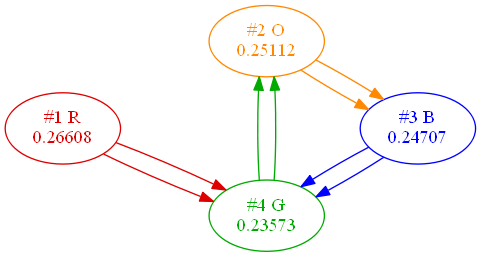

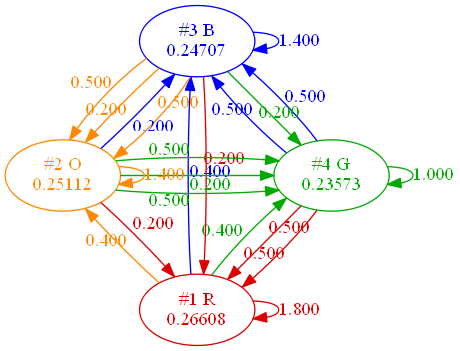

In [82]:
test = {
    'teams': [
        'R',
        'G',
        'B',
        'O',
    ],
    'teamcolors': {
        'R': '#dd0000',
        'G': '#00aa00',
        'B': '#0000ff',
        'O': '#ff8800',
    },
    'games': [
        # (a, b, a wins, b wins)
        ('R', 'G', 2, 0),
        ('G', 'B', 0, 2),
        ('B', 'O', 0, 2),
        #('O', 'R', 2, 0),
        ('G', 'O', 2, 0),
        
        #('R', 'B', 1, 1),
        #('R', 'O', 1, 1),
    ]
}
rank(**test)


6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games
      1) SS    0.14853        5/1   83     11/3   79      0
      2) IG    0.14724        5/1   83     11/3   79      0
      3) EDG   0.10528        5/1   83     10/5   67      0
      4) RW    0.08710        4/2   67      9/5   64      0
      5) BLG   0.07343        4/2   67      8/5   62      0
      5) JDG   0.07306        4/2   67      8/6   57      0
      7) SNG   0.06037        3/3   50      8/7   53      0
      7) LGD   0.06004        3/3   50      8/9   47      0
      9) WE    0.05780        3/3   50      8/7   53      0
     10) RNG   0.05267        2/4   33      6/9   40      0
     11) FPX   0.04946        2/4   33      5/9   36      0
     12) OMG   0.04502        2/4   33      6/8   43      0
     13) VG    0.02048        0/6    0      1/12   8      0
     13) TOP   0.01951        0/6    0      1/12   8      0


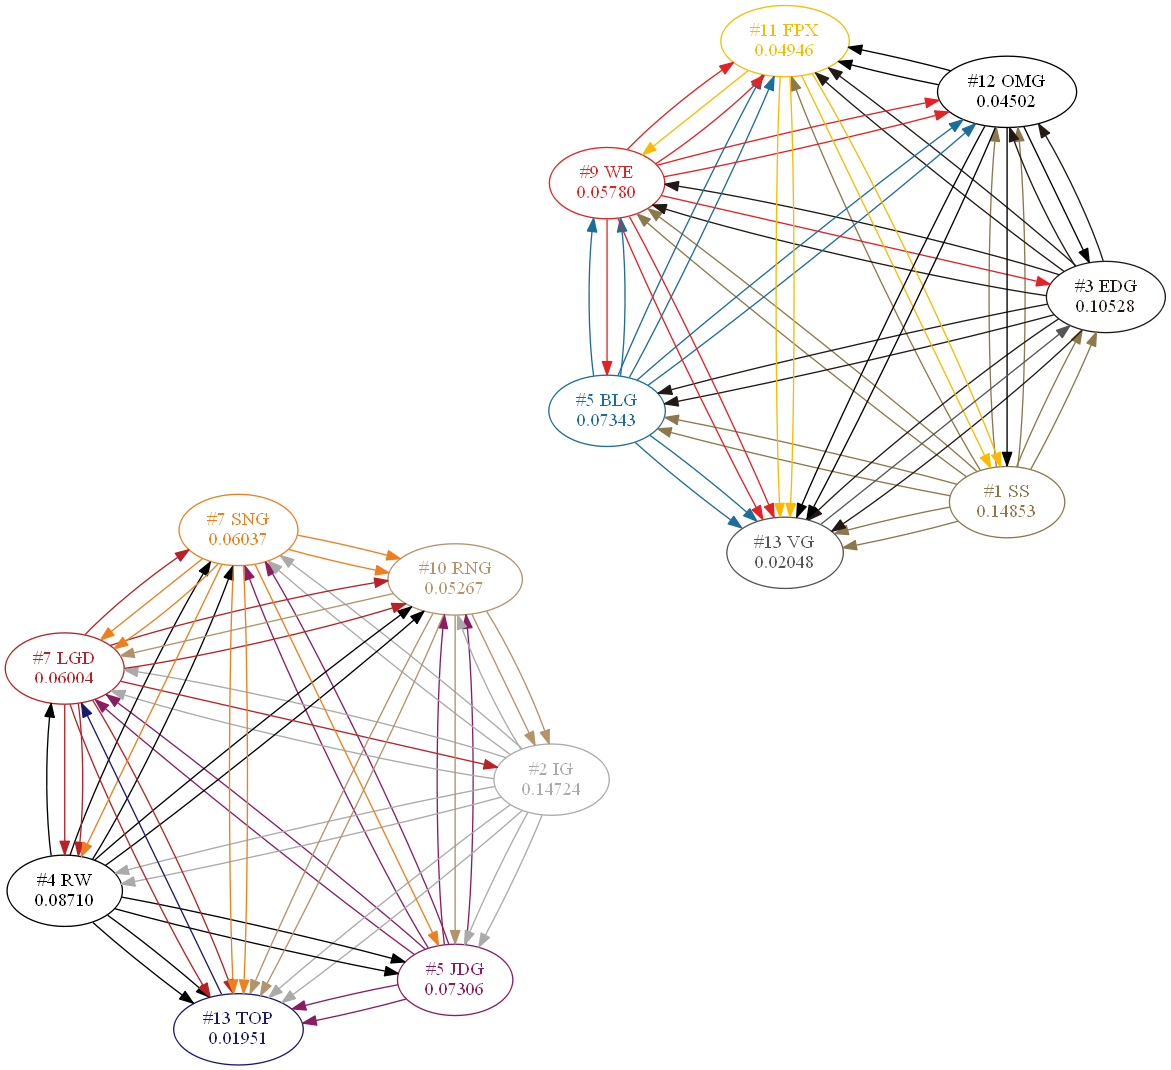

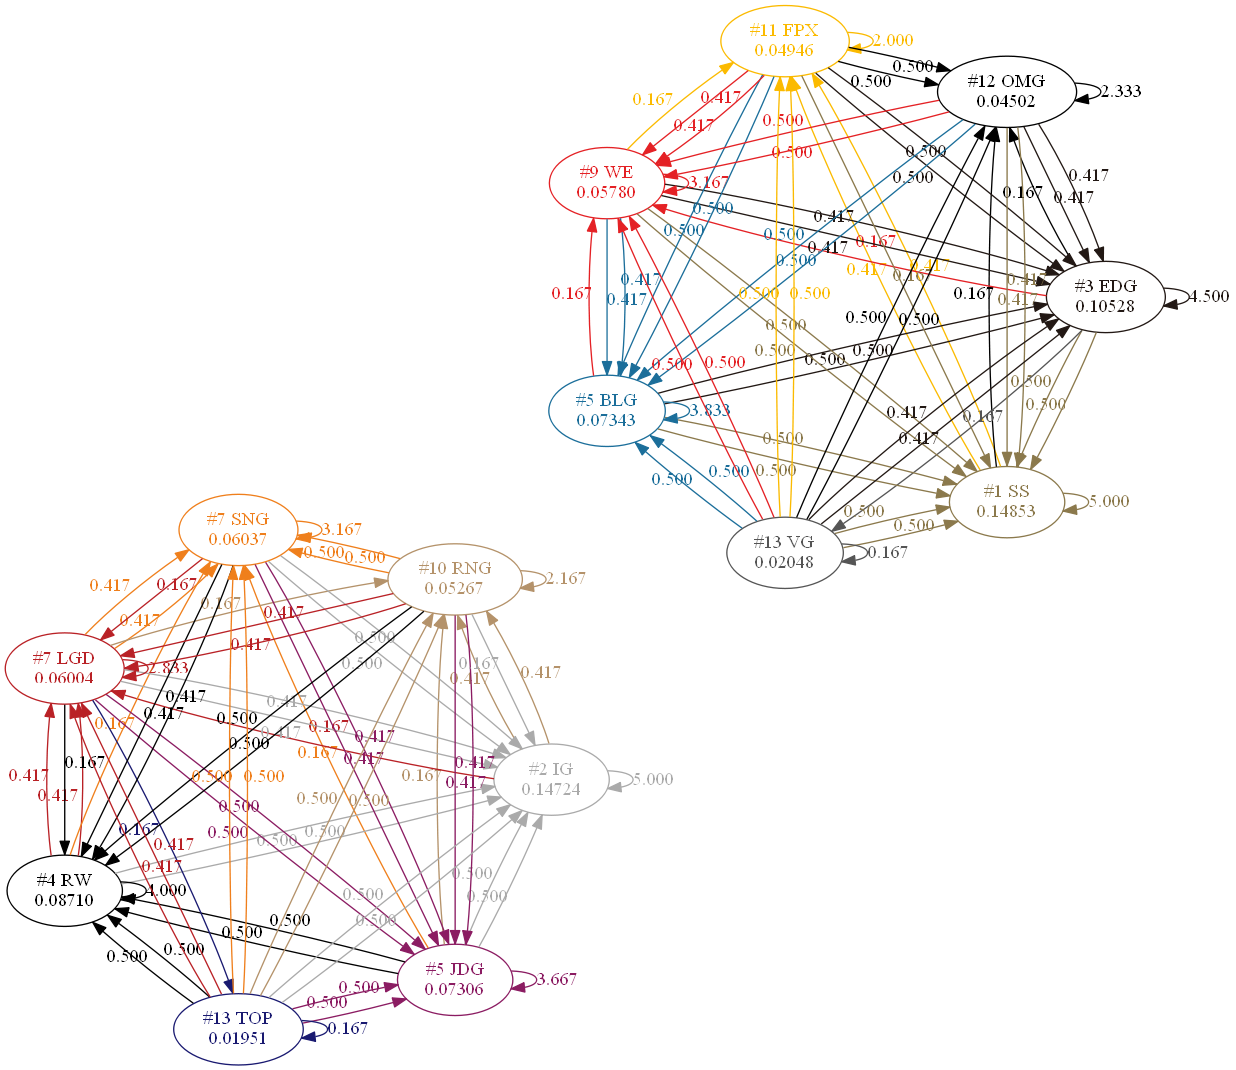

In [83]:
lpl = {
    'teams': [
        # group 1
        'SS',
        'EDG',
        'BLG',
        'WE',
        'FPX',
        'OMG',
        'VG',
        # group b
        'JDG',
        'IG',
        'RW',
        'LGD',
        'SNG',
        'RNG',
        'TOP'
    ],
    'teamcolors': {
         # group 1
        'SS': '#8b794c',
        'EDG': '#221814',
        'BLG': '#1b6e9a',
        'WE': '#e42125',
        'FPX': '#fbba00',
        'OMG': '#000000',
        'VG': '#555555',
        # group b
        'JDG': '#8b1c62',
        'IG': '#AAAAAA',
        'RW': '##e61743',
        'LGD': '#b92126',
        'SNG': '#ef7f1c',
        'RNG': '#b4926a',
        'TOP': '#191970'
    },
    'games': [
        # (a, b, a wins, b wins)
        # w,l are wins, losses for series
        # w1d1
        ('IG',  'RNG', 1, 2),
        ('SNG', 'TOP', 2, 0),
        # w1d2
        ('BLG', 'VG',  2, 0),
        ('FPX', 'EDG', 0, 2),
        # w1d3
        ('RW',  'TOP', 2, 0),
        ('JDG', 'LGD', 2, 0),
        # w1d4
        ('OMG', 'WE',  0, 2),
        ('FPX', 'SS',  2, 1),
        # w1d5
        ('TOP', 'RNG', 0, 2),
        ('RW',  'IG',  0, 2),
        ('SNG', 'LGD', 2, 1),
        # w1d6
        ('BLG', 'WE',  2, 1),
        ('FPX', 'OMG', 0, 2),
        ('EDG', 'SS',  0, 2),
        
        # w2d1
        ('RW',  'SNG', 2, 1),
        ('JDG', 'TOP', 2, 0),
        # w2d2
        ('SS',  'WE',  2, 0),
        ('RNG', 'LGD', 1, 2),
        # w2d3
        ('JDG', 'IG',  0, 2),
        ('BLG', 'OMG', 2, 0),
        # w2d4
        ('BLG', 'EDG', 0, 2),
        ('VG',  'WE',  0, 2),
        # w2d5
        ('FPX', 'WE',  1, 2),
        ('JDG', 'RNG', 2, 1),
        ('RW',  'LGD', 1, 2),
        # w2d6
        ('SS',  'VG',  2, 0),
        ('IG',  'TOP', 2, 0),
        ('EDG', 'OMG', 2, 1),
        
        # w3d1
        ('RW',  'RNG', 2, 0),
        ('JDG', 'SNG', 2, 1),
        # w3d2
        ('TOP', 'LGD', 1, 2),
        ('BLG', 'SS',  0, 2),
        # w3d3
        ('IG',  'SNG', 2, 0),
        ('VG',  'OMG', 0, 2),
        # w3d4
        ('BLG', 'FPX', 2, 0),
        ('EDG', 'VG',  2, 1),
        # w3d5
        ('JDG', 'RW',  0, 2),
        ('SNG', 'RNG', 2, 0),
        ('SS',  'OMG', 2, 1),
        # w3d6
        ('IG',  'LGD', 2, 1),
        ('FPX', 'VG',  2, 0),
        ('EDG', 'WE',  2, 1),
    ]
}
rank(**lpl)

6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games
      1) KSV   0.19491        5/1   83     10/4   71      0
      2) KZ    0.18182        5/1   83     10/2   83      0
      3) KT    0.13992        5/1   83     11/5   69      0
      4) AFS   0.13054        4/2   67      9/5   64      0
      5) KDM   0.07932        2/4   33      6/8   43      0
      6) BBQ   0.07045        2/4   33      7/9   44      0
      7) JAG   0.06744        3/3   50      6/7   46      0
      8) ROX   0.05923        2/4   33      6/10  38      0
      9) SKT   0.04341        1/5   17      5/11  31      0
     10) MVP   0.03295        1/5   17      2/11  15      0


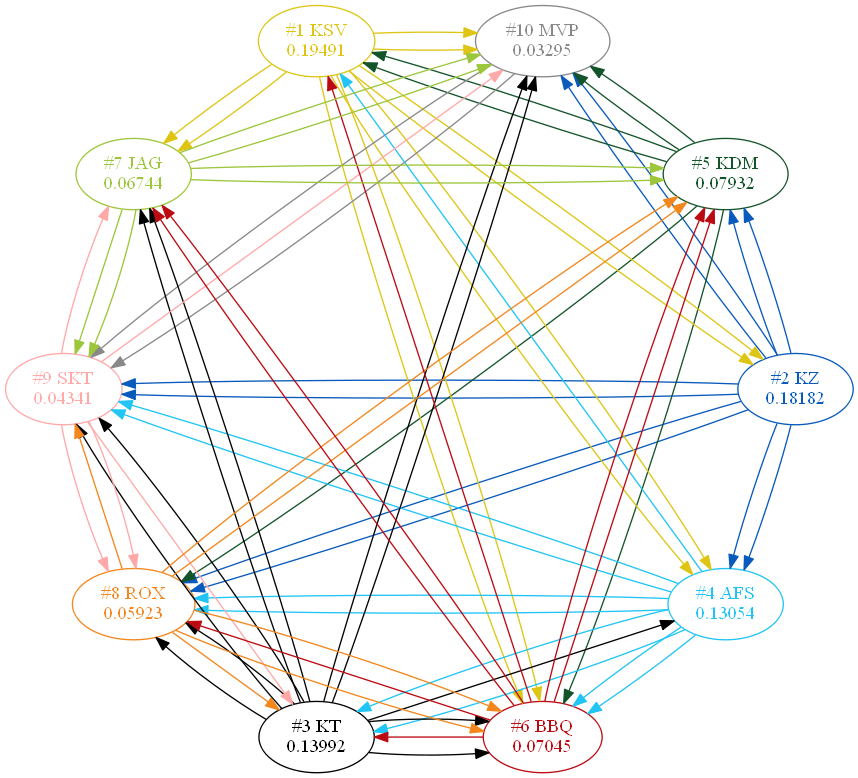

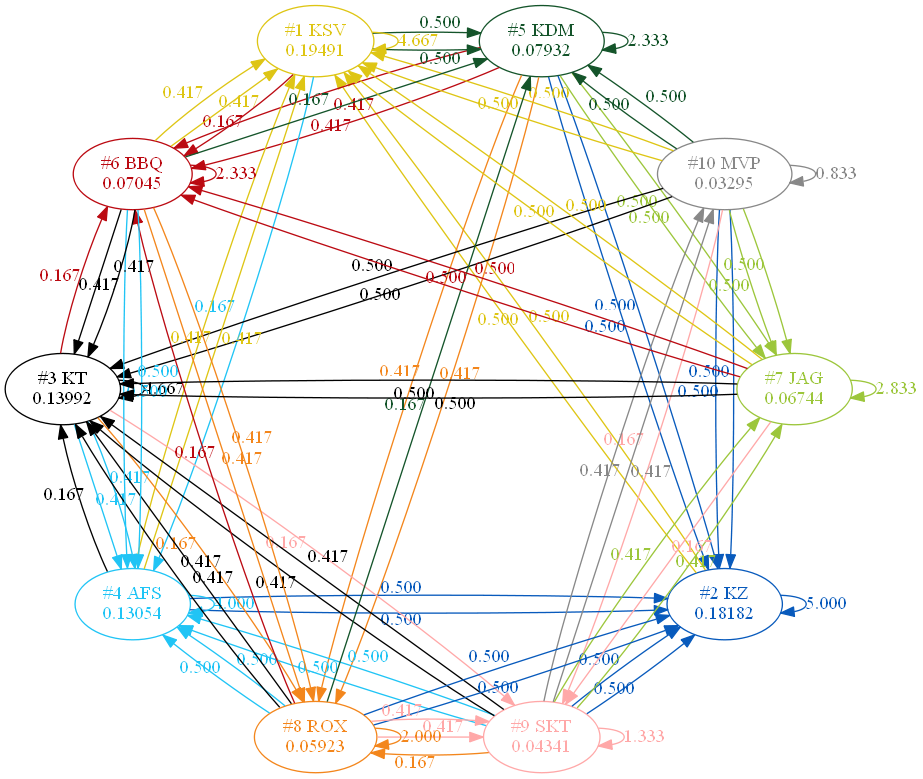

In [84]:
lck = {
    'teams': [
        'KZ',
        'KDM',
        'KSV',
        'MVP',
        'AFS',
        'KT',
        'SKT',
        'ROX',
        'BBQ',
        'JAG',
    ],
    'teamcolors': {
        'KDM': '#14542a',
        'JAG': '#9cc63b',
        'KZ': '#085abc',
        'SKT': '#ffa8a8',
        'AFS': '#20c4f5',
        'KSV': '#dec514',
        'ROX': '#f3861c',
        'BBQ': '#bb0a12',
        'MVP': '#888888',
        'KT': '#000000',
    },
    'games': [
        # (a, b, a wins, b wins)
        # w,l are wins, losses for series
        # w1d1
        ('KZ',  'KSV', 0, 2),
        ('KDM', 'MVP', 2, 0),
        # w1d2
        ('AFS', 'KT',  2, 1),
        ('SKT', 'ROX', 2, 1),
        # w1d3
        ('KDM', 'BBQ', 1, 2),
        ('JAG', 'KSV', 0, 2),
        # w1d4
        ('KT',  'MVP', 2, 0),
        ('JAG', 'SKT', 2, 1),
        
        # w2d1
        ('AFS', 'KZ',  0, 2),
        ('BBQ', 'ROX', 1, 2),
        # w2d2
        ('JAG', 'MVP', 2, 0),
        ('KT',  'SKT', 2, 1),
        # w2d3
        ('ROX', 'KDM', 2, 1),
        ('KSV', 'AFS', 2, 1),
        # w2d4
        ('KZ',  'SKT', 2, 0),
        ('KT',  'BBQ', 2, 1),
        # w2d5
        ('KSV', 'KDM', 0, 2),
        ('ROX', 'AFS',  0, 2),
        # w2d6
        ('BBQ', 'JAG', 2, 0),
        ('MVP', 'KZ',  0, 2),
        
        # w3d1
        ('MVP', 'KSV', 0, 2),
        ('KDM', 'JAG', 0, 2),
        # w3d2
        ('KZ',  'ROX', 2, 0),
        ('AFS', 'BBQ', 2, 0),
        # w3d3
        ('KT',  'JAG', 2, 0),
        ('MVP', 'SKT', 2, 1),
        # w3d4
        ('KZ',  'KDM', 2, 0),
        ('KSV', 'BBQ', 2, 1),
        # w3d5
        ('ROX', 'KT',  1, 2),
        ('SKT', 'AFS', 0, 2),
    ]
}
rank(**lck)

5
5
5
5
5
5
5
5
5
5
      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games
      1) FOX   0.16983        4/1   80      4/1   80      0
      2) 100   0.16509        4/1   80      4/1   80      0
      3) C9    0.16316        4/1   80      4/1   80      0
      4) TL    0.13914        4/1   80      4/1   80      0
      5) CLG   0.08328        2/3   40      2/3   40      0
      6) CG    0.06808        2/3   40      2/3   40      0
      7) FLY   0.06437        2/3   40      2/3   40      0
      8) TSM   0.06220        2/3   40      2/3   40      0
      9) OPT   0.04985        1/4   20      1/4   20      0
     10) GGS   0.03500        0/5    0      0/5    0      0


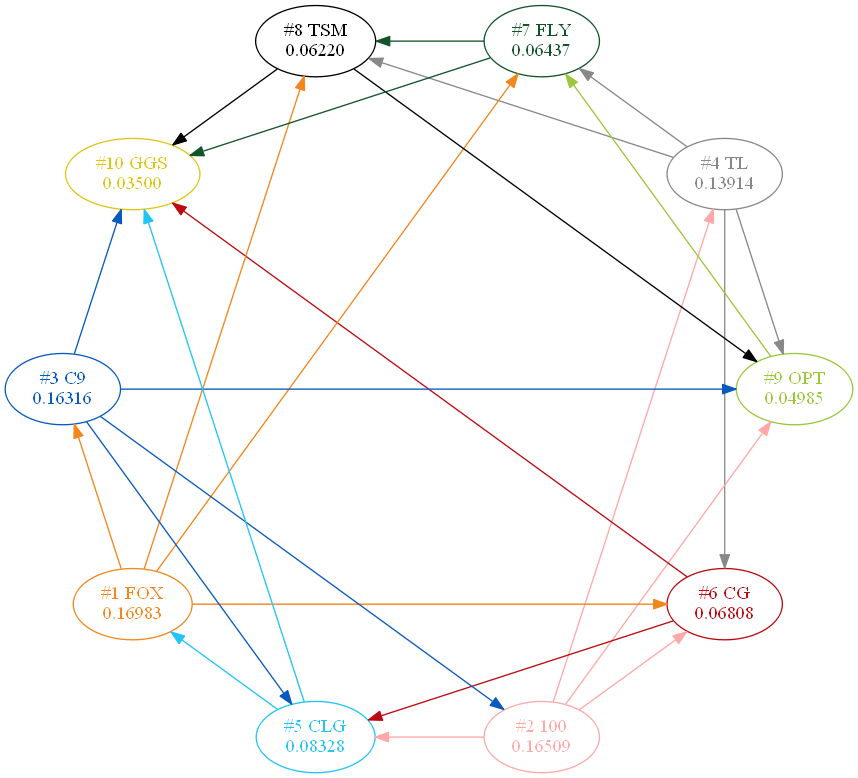

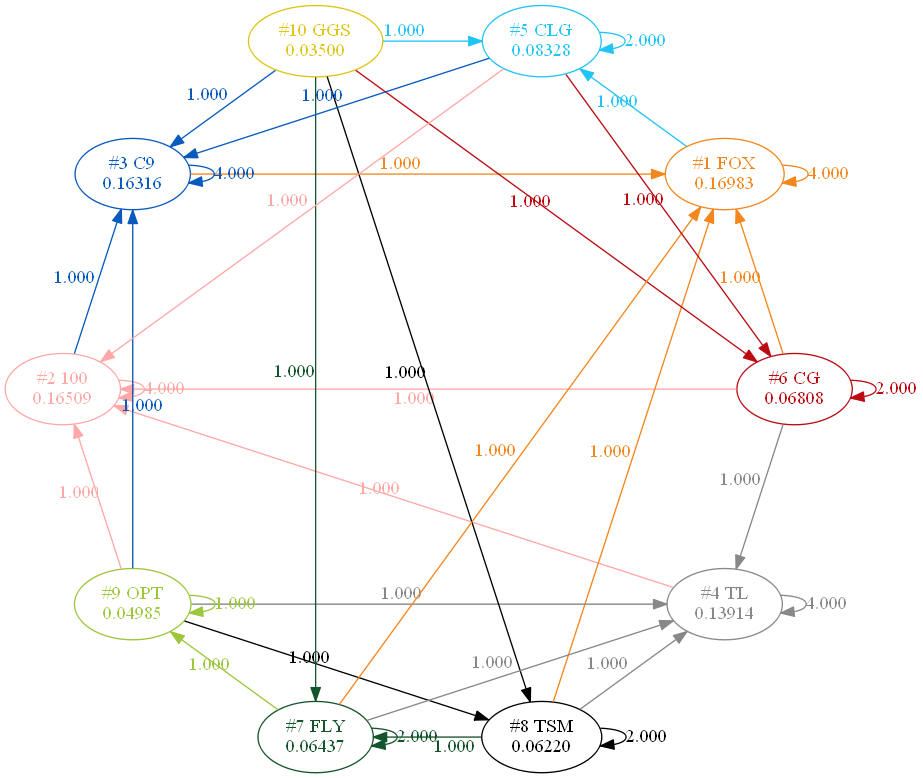

In [66]:
nalcs = {
    'teams': [
        'TL',
        '100',
        'CG',
        'FOX',
        'C9',
        'TSM',
        'OPT',
        'GGS',
        'FLY',
        'CLG',
    ],
    'teamcolors': {
        'TL': '#888888',
        '100': '#ffa8a8',
        'CG': '#bb0a12',
        'FOX': '#f3861c',
        'C9': '#085abc',
        'TSM': '#000000',
        'OPT': '#9cc63b',
        'GGS': '#dec514',
        'FLY': '#14542a',
        'CLG': '#20c4f5',
    },
    'games': [
        # (winner, loser)
        # w1d1
        ('TL',  'TSM'),
        ('100', 'OPT'),
        ('CG',  'GGS'),
        ('FOX', 'FLY'),
        ('C9', 'CLG'),
        # w1d2
        ('TL',  'OPT'),
        ('FLY', 'TSM'),
        ('100', 'CLG'),
        ('C9',  'GGS'),
        ('FOX', 'CG'),
        # w2d1
        ('CG',  'CLG'),
        ('TSM', 'OPT'),
        ('FOX', 'C9'),
        ('100', 'TL'),
        ('FLY', 'GGS'),
        # w2d2
        ('FOX', 'TSM'),
        ('C9',  '100'),
        ('OPT', 'FLY'),
        ('CLG', 'GGS'),
        ('TL',  'CG'),
        # w3d1
        ('CLG', 'FOX'),
        ('C9',  'OPT'),
        ('100', 'CG'),
        ('TL',  'FLY'),
        ('TSM', 'GGS'),
    ]
}
rank(**nalcs)

6
6
6
6
6
6
6
6
6
6
      PR TEAM  PR-SCORE     S W/L    %    G W/L    %    missing games
      1) VIT   0.17156        5/1   83      5/1   83      0
      2) MSF   0.14064        4/2   67      4/2   67      0
      3) GIA   0.11627        4/2   67      4/2   67      0
      4) G2    0.09812        3/3   50      3/3   50      0
      4) FNC   0.09760        3/3   50      3/3   50      0
      6) SPY   0.09654        3/3   50      3/3   50      0
      7) S04   0.09232        3/3   50      3/3   50      0
      8) ROC   0.09039        3/3   50      3/3   50      0
      9) H2K   0.05111        1/5   17      1/5   17      0
     10) UOL   0.04546        1/5   17      1/5   17      0


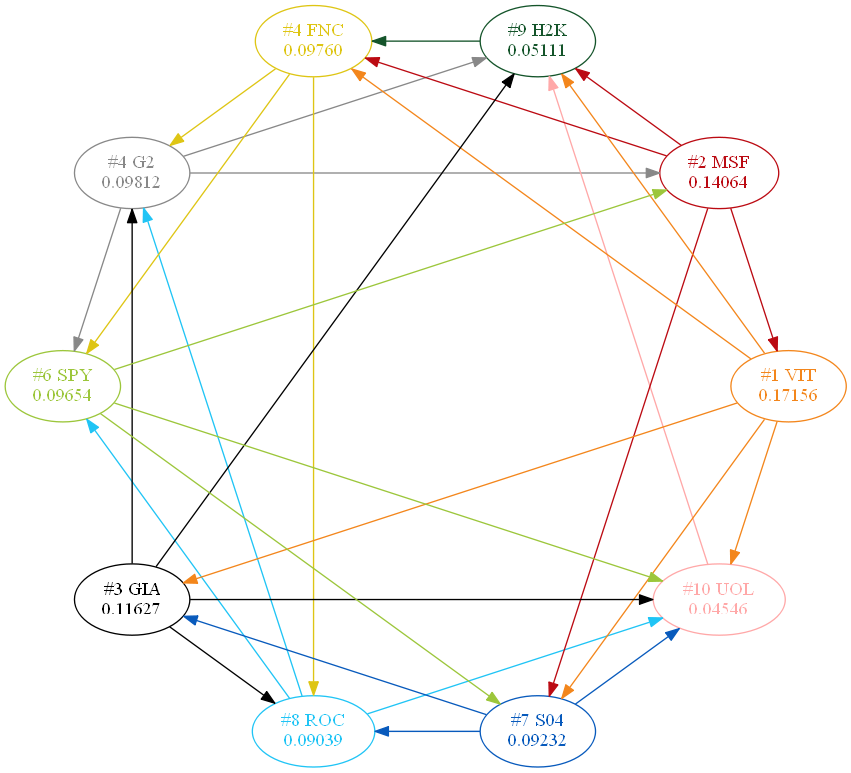

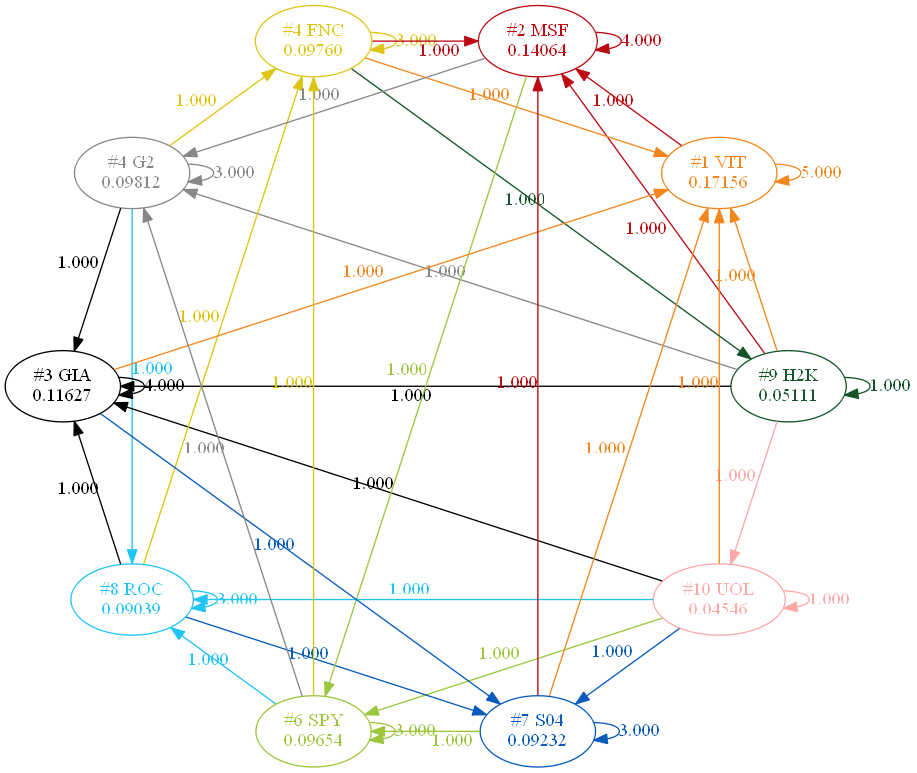

In [67]:
eulcs = {
    'teams': [
        'G2',
        'H2K',
        'UOL',
        'ROC',
        'FNC',
        'MSF',
        'VIT',
        'GIA',
        'S04',
        'SPY',
    ],
    'teamcolors': {
        'G2': '#888888',
        'UOL': '#ffa8a8',
        'VIT': '#f3861c',
        'MSF': '#bb0a12',
        'S04': '#085abc',
        'ROC': '#20c4f5',
        'GIA': '#000000',
        'SPY': '#9cc63b',
        'FNC': '#dec514',
        'H2K': '#14542a',
    },
    'games': [
        # (winner, loser)
        # w1d1
        ('G2',  'MSF'),
        ('VIT', 'H2K'),
        ('GIA', 'UOL'),
        ('S04', 'ROC'),
        ('FNC', 'SPY'),
        # w1d2
        ('VIT', 'GIA'),
        ('SPY', 'UOL'),
        ('H2K', 'FNC'),
        ('ROC', 'G2'),
        ('MSF', 'S04'),
        # w2d1
        ('GIA', 'G2'),
        ('ROC', 'SPY'),
        ('MSF', 'H2K'),
        ('VIT', 'FNC'),
        ('S04', 'UOL'),
        # w2d2
        ('GIA', 'H2K'),
        ('ROC', 'UOL'),
        ('MSF', 'VIT'),
        ('SPY', 'S04'),
        ('FNC', 'G2'),
        # w3d1
        ('UOL', 'H2K'),
        ('GIA', 'ROC'),
        ('VIT', 'S04'),
        ('G2',  'SPY'),
        ('MSF', 'FNC'),
        # w3d2
        ('VIT', 'UOL'),
        ('S04', 'GIA'),
        ('FNC', 'ROC'),
        ('G2',  'H2K'),
        ('SPY', 'MSF'),
    ]
}
rank(**eulcs)

      PR TEAM  PR-SCORE    S W/L %     G W/L %
      1) KSV   0.22842       3/0 100     6/1  86
      2) BBQ   0.12604       2/1  67     5/3  62
      3) ROX   0.12470       2/1  67     5/4  56
      4) KT    0.10291       2/1  67     5/3  62
      5) KZ    0.09983       2/1  67     4/2  67
      6) SKT   0.07992       1/2  33     4/5  44
      7) AFS   0.07964       1/2  33     3/5  38
      8) KDM   0.07500       1/2  33     4/4  50
      9) JAG   0.05854       2/2  50     4/5  44
     10) MVP   0.02500       0/4   0     0/8   0